# Sentiment Analysis

In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

Device: cuda


### Dataset preparation

In [ ]:
from datasets import load_dataset
from openai import OpenAI

llm = OpenAI(
           base_url = "https://api.endpoints.anyscale.com/v1",
           api_key=os.environ['ANYSCALE_API_KEY'],
        )

In [ ]:
imdb = load_dataset('stanfordnlp/imdb')

In [ ]:
import re
import json

def summarize(prompt, max_new_tokens=256):
    try:
        response = llm.chat.completions.create(
                    model = "meta-llama/Meta-Llama-3-70B-Instruct",
                    messages = [
                            {'role': 'user', 'content': f"Rewrite the following text in one sentence. Output only a single json file with a single field 'new_text'.\n{prompt}"},
                        ],
                    temperature=1,
                    max_tokens=max_new_tokens,
                )
                
        out = response.choices[0].message.content

        json_pattern = r"{.*?}"

        # Find all occurrences of JSON in the text
        match = re.findall(json_pattern, out)[0]
        json_data = json.loads(match)
        new_text = json_data["new_text"]

        return new_text
    except Exception as e:
        return out

In [ ]:
df = pd.DataFrame(imdb['train']).groupby('label').sample(250, random_state=42)
df['summary'] = df['text'].progress_apply(summarize)

### Data and model loading

In [3]:
df = pd.read_csv("imdb.csv")

train = pd.concat([
    df.iloc[:100],
    df.iloc[250:350],
], axis=0)

val = pd.concat([
    df.iloc[100:150],
    df.iloc[350:400],
], axis=0)

test = pd.concat([
    df.iloc[150:250],
    df.iloc[400:500],
], axis=0)

len(train), len(val), len(test)

(200, 100, 200)

In [4]:
model = HookedTransformer.from_pretrained('gemma-2b')

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


### Baseline

In [5]:
n_shots = 4

shots = pd.concat([
    val.iloc[:n_shots//2],
    val.iloc[50:50+n_shots//2],
], axis=0)

len(train), len(shots)

(200, 4)

In [6]:
import random

map = {
    1: 'positive',
    0: 'negative'
}

def generate_prompt(x, shots):
    prompt = ""

    for i in random.sample(range(n_shots), n_shots):
        shot = shots.iloc[i]
        prompt += f"{shot['summary']} | {map[shot['label']]}\n\n"

    prompt += x + " |"
    return prompt

In [ ]:
tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
preds = []
for i in tqdm(range(len(train))):
    x = test.iloc[i]
    prompt = generate_prompt(x['summary'], shots)
    
    with torch.no_grad():
        proba = model(model.to_tokens(prompt)).softmax(-1)

    preds.append(proba[0, -1, tokens].tolist())

preds = np.array(preds)
train['pred_positive'] = preds[:, 0]
train['pred_negative'] = preds[:, 1]

In [ ]:
train['pred'] = train.apply(lambda x: 1 if x['pred_positive'] > x['pred_negative'] else 0, axis=1)
train['correct'] = train['label'] == train['pred']

In [ ]:
train.groupby('label')['correct'].mean()

In [ ]:
results_df = pd.DataFrame({
    'shots': [2, 4, 6, 8, 10],
    'pos_score': [0.97, 0.96, 0.94, 0.94, 0.94],
    'neg_score': [0.93, 0.93, 0.97, 0.96, 0.94]
})

sns.lineplot(
    results_df.melt(id_vars='shots', var_name='score'),
    x='shots', y='value', hue='score'
)

## Attribution Pathcing 

In [7]:
def get_cache_fwd_and_bwd(tokens, ans_clean, ans_corr=None):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        logits = model(tokens)
        value = logits[:, -1, ans_clean]
        if ans_corr is not None:
            value -= logits[:, -1, ans_corr]
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [8]:
ans_tokens = [model.to_single_token(tok) for tok in [' negative', ' positive']]
patches = []

for i in tqdm(range(len(train))):
    x = test.iloc[i]
    
    y = x.label
    a_clean = ans_tokens[y]
    a_corr = ans_tokens[1 - y]
    
    prompt = generate_prompt(x['summary'], shots)

    #
    _, cache, grad_cache = get_cache_fwd_and_bwd(model.to_tokens(prompt), a_clean, a_corr)

    act = cache.stack_head_results(-1)
    grad_act = grad_cache.stack_head_results(-1)

    patches.append(einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos",
                "sum",
        ))

    break

  0%|          | 0/200 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 23.68 GiB total capacity; 23.31 GiB already allocated; 79.62 MiB free; 23.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Heads Boost

In [274]:
def head_modifier_hook(x, hook, head_id, lam=1.2):
    x[:, -1, head_id, :] = lam * x[:, -1, head_id, :]
    return x

In [276]:
prompt = generate_prompt(test.iloc[-2]['summary'], train)
print(prompt)

This film about a vengeful ghost is an unremarkable combination of GASLIGHT and LES DIABOLIQUES, featuring 10 big-name stars, including Cliff Robertson and Jean Simmons, despite its cliché-ridden and mediocre script. | negative

I saw The Glacier Fox at age nine and have been searching for it on video, hoping it will be re-released or picked up by a new distributor for regular showings, as it's a captivating film with a great soundtrack that would resonate with today's audiences. | positive

Reed Hadley's serial features the best theme song and Yakima Canutt's incredible stagecoach stunt, making it a must-see despite its lower budget and Hadley's less impressive portrayal of Zorro. | positive

This film chronicles the attempts of an elderly saxophone player to reform her all-girl band from WWII, featuring an all-star cast including Ian Holm, Judi Dench, and Leslie Caron, in a nostalgic and entertaining romp down memory lane. | positive

The movie 'The Wayward Cloud' features disturbing

In [279]:
# [(8, 11, -1), (9, 6, 1), (9, 9, 1), (10, 0, 1), (10, 1, 1), (10, 7, -1), (10, 10, 1), (11, 10, -1)]
heads = [(8, 11), (9, 6), (10, 0), (10, 1)]

topk_token_probas = []  # List to store topk token probabilities
lams = np.linspace(1, 15, 20)

for lam in tqdm(lams):
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)
        
        vals = proba[..., tokens]
        
        topk_token_probas.append(vals[0, -1, :].cpu().numpy().tolist())


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


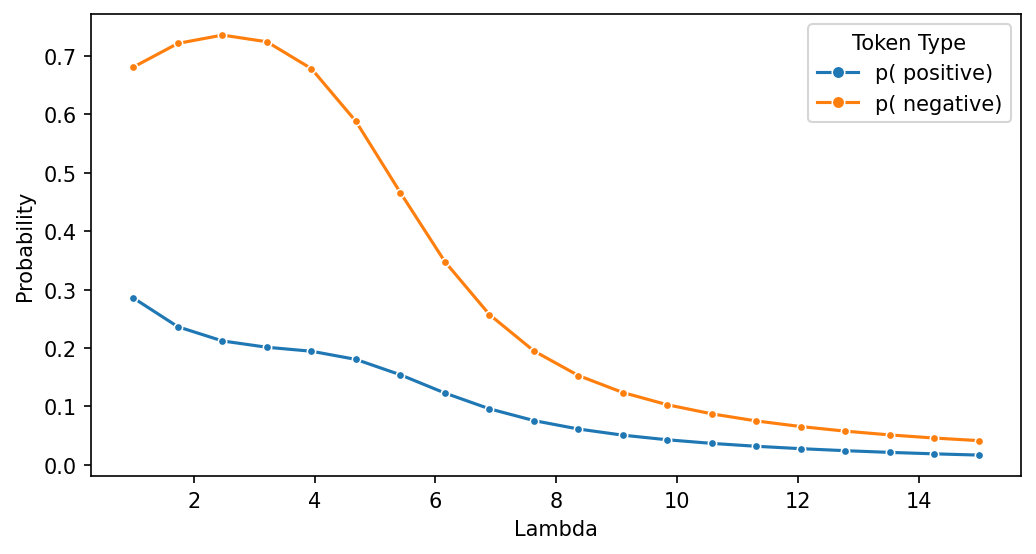

In [280]:
import pandas as pd

fig = plt.figure(figsize=(8, 4), dpi=150)

data = pd.DataFrame(topk_token_probas, columns=[f"p({tok})" for tok in model.to_str_tokens(torch.tensor(tokens))])
data['Lambda'] = lams
data = data.melt(id_vars='Lambda', var_name='Token Type', value_name='Probability')

ax = sns.lineplot(data=data, x='Lambda', y='Probability', hue='Token Type', marker='o')
tmp =[line.set_markersize(4) for line in ax.lines]

In [281]:
lam = 7

tokens = model.to_tokens(prompt)
max_new_tokens = 4

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

<|endoftext|>This film about a vengeful ghost is an unremarkable combination of GASLIGHT and LES DIABOLIQUES, featuring 10 big-name stars, including Cliff Robertson and Jean Simmons, despite its cliché-ridden and mediocre script. | negative

I saw The Glacier Fox at age nine and have been searching for it on video, hoping it will be re-released or picked up by a new distributor for regular showings, as it's a captivating film with a great soundtrack that would resonate with today's audiences. | positive

Reed Hadley's serial features the best theme song and Yakima Canutt's incredible stagecoach stunt, making it a must-see despite its lower budget and Hadley's less impressive portrayal of Zorro. | positive

This film chronicles the attempts of an elderly saxophone player to reform her all-girl band from WWII, featuring an all-star cast including Ian Holm, Judi Dench, and Leslie Caron, in a nostalgic and entertaining romp down memory lane. | positive

The movie 'The Wayward Cloud' featur

In [282]:
tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
lam = 7

preds = []
for i in tqdm(range(len(test))):
    x = test.iloc[i]
    prompt = generate_prompt(x['summary'], train)
    
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)

    preds.append(proba[0, -1, tokens].tolist())

preds = np.array(preds)
test['boost_pred_positive'] = preds[:, 0]
test['boost_pred_negative'] = preds[:, 1]

100%|██████████| 492/492 [03:57<00:00,  2.07it/s]


In [283]:
test['boost_pred'] = test.apply(lambda x: 1 if x['boost_pred_positive'] > x['boost_pred_negative'] else 0, axis=1)
test['boost_correct'] = test['label'] == test['boost_pred']

In [284]:
test.groupby('label')['boost_correct'].mean()

label
0    1.000000
1    0.077236
Name: boost_correct, dtype: float64